In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import time
import pathlib
import os
import matplotlib.pyplot as plt
import re

from PIL import Image
from model.decoder import Decoder
from model.encoder import CNN_Encoder
from model.attention import BahdanauAttention
from model.decoder import embedding_initializer
from components.positional import add_timing_signal_nd
from sklearn.model_selection import train_test_split

## Dataset

In [2]:
def get_matches(match_file, images_dir, formulas):
    """
    Args:
        match_file: path of file where the file containing matches live. 
            match_file can take values {test.matching.txt, train.matching.txt, val.matching.txt}
        images_dir: directory where the images live. 
            Can take the following values only: ./data/ + {images_test, images_train, val_train}
        formulas: arr containg formulas.
            Formulas should come from one of the following files: {test.formulas.norm.txt, train.formulas.norm.txt, val.formulas.norm.txt}
            
    Return:
        matching_formulas: arr of formulas that matches the imgs. 
            Must be same length as matching_images_paths. Each index corresponds to an img in matchign_images_paths at equal index
        matching_images_paths: arr of imgs that match formulas.
            Must be same length as matching_formulas. Each index corresponds to formula in matching_formula at equal index
    
    """
    matching_formulas = []
    matching_images_paths = []
    
    matches = open(match_file).read().split('\n')
    
    for match in matches:
        # check if empty since last line is always empty
        if len(match) != 0:
            # tuple with form (img file name, formula line)
            match_tuple = match.split(' ')
            # file name
            img_name = match_tuple[0]
            # line number in formula_file
            idx = int(match_tuple[1])

            # get the image path
            img_path = os.fspath(os.path.join(os.curdir, images_dir, img_name))
            # add start and end tokens
            formula = "<start> " + formulas[idx] + " <end>"

            matching_images_paths.append(img_path)
            matching_formulas.append(formula)
        
    return matching_images_paths, matching_formulas

In [3]:
all_test_formulas = open("data/test.formulas.norm.txt").read().split('\n')
all_train_formulas = open("data/train.formulas.norm.txt").read().split('\n')
all_val_formulas = open("data/val.formulas.norm.txt").read().split('\n')

In [4]:
test_images, test_formulas = get_matches("data/test.matching.txt", "data/images_test", all_test_formulas)
train_images, train_formulas = get_matches("data/train.matching.txt", "data/images_train", all_train_formulas)
val_images, val_formulas = get_matches("data/val.matching.txt", "data/images_val", all_val_formulas)

In [5]:
len(test_images), len(test_formulas)

(9442, 9442)

In [6]:
len(train_images), len(train_formulas)

(76304, 76304)

In [7]:
len(val_images), len(val_formulas)

(8474, 8474)

In [8]:
all_formulas = test_formulas + train_formulas + val_formulas

## Tokenize

In [9]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
top_k = 400

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='')
tokenizer.fit_on_texts(all_formulas)
train_seqs = tokenizer.texts_to_sequences(train_formulas)

In [11]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [12]:
train_formula_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [13]:
max_length = calc_max_length(train_seqs)

## Split Dataset

In [14]:
embedding_dim = 80
BATCH_SIZE = 20
units = 512
vocab_size = top_k + 1
attention_features_shape = 64

In [15]:
def load_image(image_path, formula):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img)
    img = tf.image.resize_with_pad(img, 300, 50)
    return img, formula

In [16]:
def load_image_only(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize_with_pad(img, 300, 50)
    img = img / 255
    return img 

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_formula_vector))


In [18]:
dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [19]:
dataset = dataset.shuffle(1000).batch(BATCH_SIZE)

In [20]:
num_steps = len(train_images)

## Init Encoder Decoder

In [21]:
encoder = CNN_Encoder(embedding_dim)

In [22]:
decoder = Decoder(embedding_dim, 512, vocab_size=top_k+1,)

## Loss

In [23]:
loss_plot = []

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

## Training

In [25]:
@tf.function
def train_step(img, target):
    loss = 0
    img = img / 255
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img)
        
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)
            
            dec_input = tf.expand_dims(target[:, i], 1)
            
        total_loss = (loss / int(target.shape[1]))
        
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        
        gradients = tape.gradient(loss, trainable_variables)
        
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        return loss, total_loss
    

## Checkpoints

In [26]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [27]:
start_epoch = 0

if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restore to latest cehckpoint
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [28]:
EPOCHS = 35

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, target)
        total_loss += t_loss
    
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        
    loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()
        
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


ValueError: in user code:

    <ipython-input-25-c37b197b996d>:10 train_step  *
        features = encoder(img)
    /Users/frankpalma/Projects/img2latex/model/encoder.py:52 call  *
        x = self.dense(x)
    /Users/frankpalma/Projects/img2latex/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:982 __call__  **
        self._maybe_build(inputs)
    /Users/frankpalma/Projects/img2latex/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2643 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /Users/frankpalma/Projects/img2latex/env/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:1171 build
        self.kernel = self.add_weight(
    /Users/frankpalma/Projects/img2latex/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:597 add_weight
        variable = self._add_variable_with_custom_getter(
    /Users/frankpalma/Projects/img2latex/env/lib/python3.8/site-packages/tensorflow/python/training/tracking/base.py:730 _add_variable_with_custom_getter
        checkpoint_initializer = self._preload_simple_restoration(
    /Users/frankpalma/Projects/img2latex/env/lib/python3.8/site-packages/tensorflow/python/training/tracking/base.py:797 _preload_simple_restoration
        return CheckpointInitialValue(
    /Users/frankpalma/Projects/img2latex/env/lib/python3.8/site-packages/tensorflow/python/training/tracking/base.py:75 __init__
        self.wrapped_value.set_shape(shape)
    /Users/frankpalma/Projects/img2latex/env/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1207 set_shape
        raise ValueError(

    ValueError: Tensor's shape (12288, 80) is not compatible with supplied shape [17920, 80]


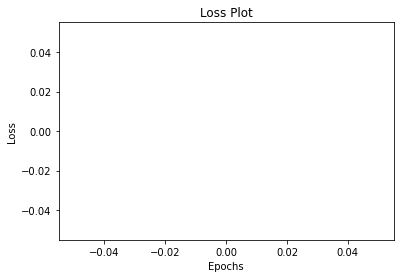

In [29]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
        
    img = tf.expand_dims(load_image_only(image), 0) 
    
    features = encoder(img)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    
    attention_plot = attention_plot[:len(result), :]
    
    return result, attention_plot
    
    

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Formula:', real_caption)
print ('Prediction Formula:', ' '.join(result))

In [ ]:
for img in dataset:
    print(img.shape)
    